# Exploring Static Training

This notebook visualizes the results from `training_static_masks.py`, which uses our mask model defined in `SelectionMask.py`.

## The Mask Model (`SelectionMask`)

Our mask model is a PyTorch `nn.Module` that creates and optimizes a binary mask to select specific regions in an image.

The mask is initialized randomly based on the methods described in our referenced article. It can be applied directly to an image or be optimized by an optimizer to achieve a specific goal. We also use a loss function that calculates the percentage of the mask with a value of 1, which represents the percentage of selected pixels.

## The Training Loop
We used the same classifier and dataset as defined in `mnist-cnn.ipynb`. Our goal wasn't to find the best model configuration or the optimal training loop, but rather to validate our mask model.

The notebook is considered a success if we can demonstrate that:
- **Initialization**: The mask can be initialized properly.
- **Application**: The mask can be applied to images correctly.
- **Optimization**: The mask and its loss function can be properly optimized using gradient descent.
- **End-to-end Training**: The mask and the classifier model can be trained together in an end-to-end manner.

In [32]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [33]:
torch.set_default_device('cuda')

In [34]:
import SelectionMask as sm
import utils as u

In [35]:
def load_checkpoints(training_id):
    i = 0
    while True:
        try: 
            state_dict = torch.load(f"./trainings/{training_id}/checkpoint_epoch_{i + 1}.pt", map_location='cpu')
            yield state_dict
            del state_dict
            torch.cuda.empty_cache()
            i += 1
        except FileNotFoundError:
            break

## With ADAM

/tmp/ipykernel_54976/3850813232.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./trainings/{training_id}/checkpoint_epoch_{i + 1}.pt", map_loc

ValueError: attempt to get argmax of an empty sequence

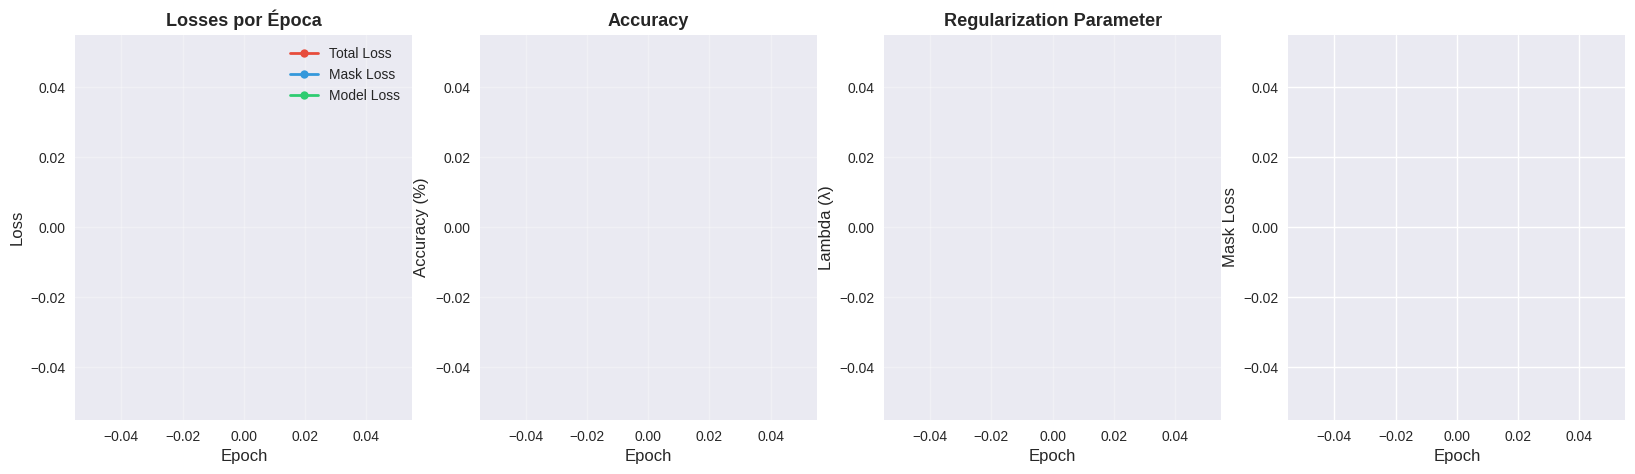

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import math

epochs = []
total_losses = []
accuracies = []
lambdas = []
mask_loss = []
model_loss = []

for check in load_checkpoints("cnn_mnist_run_ADAM_new_mask_01"):
    epochs.append(check['epoch'])
    total_losses.append(check['total_loss'])
    accuracies.append(check['accuracy'])
    lambdas.append(check['lambda'])
    mask_loss.append(check['mask_loss'])
    model_loss.append(check['model_loss'])

relations = (1-np.array(mask_loss)) * accuracies

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 4, figsize=(20, 5))


# Total Loss + Mask Loss + Model Loss
axes[0].plot(epochs, total_losses, 'o-', color='#e74c3c', linewidth=2, markersize=6, label='Total Loss')
axes[0].plot(epochs, mask_loss,   'o-', color='#3498db', linewidth=2, markersize=6, label='Mask Loss')
axes[0].plot(epochs, model_loss,  'o-', color='#2ecc71', linewidth=2, markersize=6, label='Model Loss')

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Losses por Época', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Accuracy
axes[1].plot(epochs, accuracies, 'o-', color='#2ecc71', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Lambda
axes[2].plot(epochs, lambdas, 'o-', color='#3498db', linewidth=2, markersize=6)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Lambda (λ)', fontsize=12)
axes[2].set_title('Regularization Parameter', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Relationships
axes[3].plot(epochs, relations, 'o-', color='#3498db', linewidth=2, markersize=6)
axes[3].set_xlabel('Epoch', fontsize=12)
axes[3].set_ylabel('Mask Loss', fontsize=12)
axes[3].set_title(f'Best Epoch: {np.argmax(relations)}', fontsize=13, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## With SGD

/tmp/ipykernel_54976/3850813232.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./trainings/{training_id}/checkpoint_epoch_{i + 1}.pt", map_loc

TypeError: Invalid shape (3, 32, 32) for image data

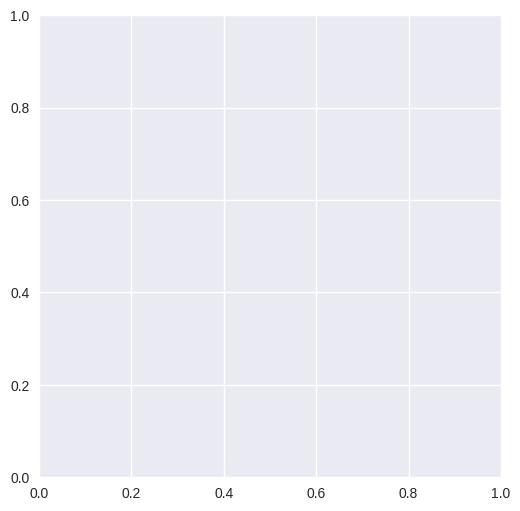

In [39]:
masks = []

for i, checkpoint in enumerate(load_checkpoints("resNet_cifar10_run_ADAM_01")):
    loss = checkpoint['mask_loss']
    s = checkpoint['lambda']
    accuracy = checkpoint['accuracy']
    model = checkpoint['model_state_dict']
    mask = checkpoint['mask_state_dict']
    mask = mask['mask'].squeeze().cpu().detach().numpy()
    rounded = (mask + 0.5).astype(int)
    masks.append(rounded)
    
u.animate_notebook(masks, cmap="gray", vmin=0, vmax=1)

/tmp/ipykernel_54976/3850813232.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./trainings/{training_id}/checkpoint_epoch_{i + 1}.pt", map_loc

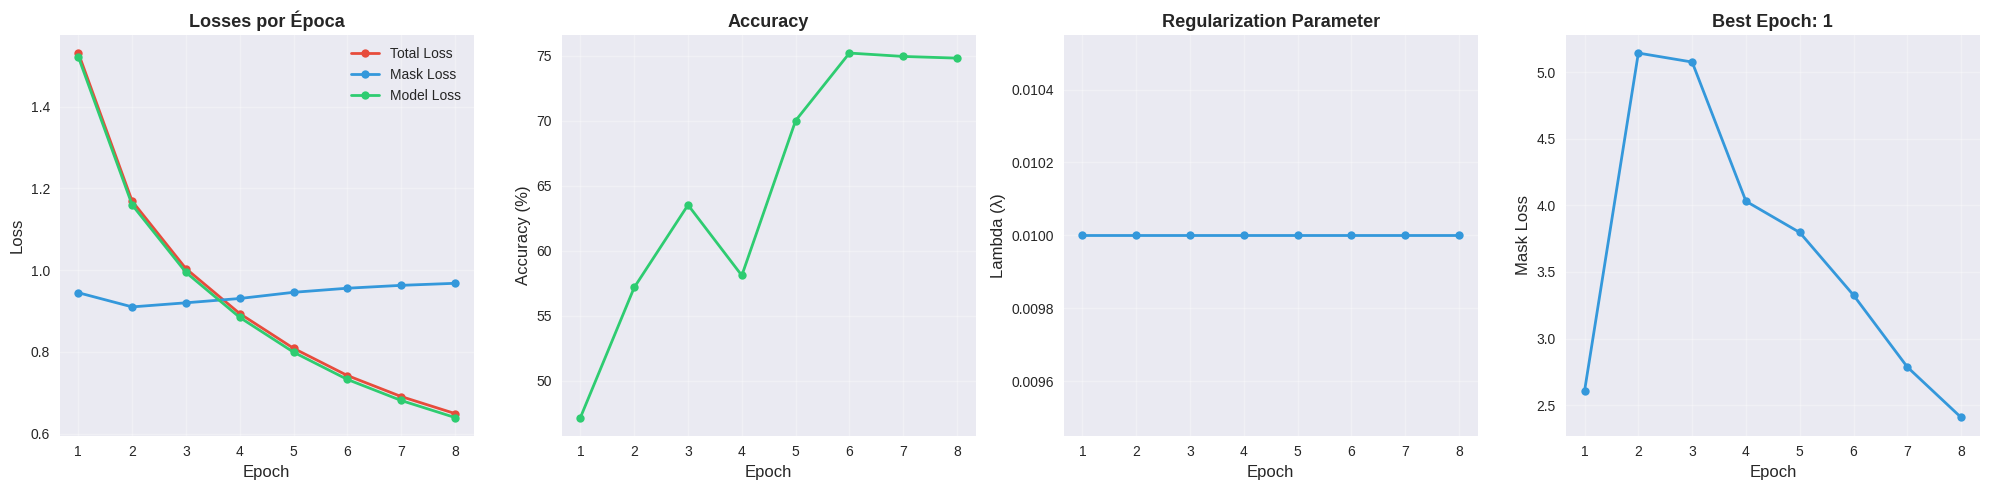

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import math

epochs = []
total_losses = []
accuracies = []
lambdas = []
mask_loss = []
model_loss = []

for check in load_checkpoints("resNet_cifar10_run_ADAM_01"):
    epochs.append(check['epoch'])
    total_losses.append(check['total_loss'])
    accuracies.append(check['accuracy'])
    lambdas.append(check['lambda'])
    mask_loss.append(check['mask_loss'])
    model_loss.append(check['model_loss'])

relations = (1-np.array(mask_loss)) * accuracies

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(1, 4, figsize=(20, 5))


# Total Loss + Mask Loss + Model Loss
axes[0].plot(epochs, total_losses, 'o-', color='#e74c3c', linewidth=2, markersize=6, label='Total Loss')
axes[0].plot(epochs, mask_loss,   'o-', color='#3498db', linewidth=2, markersize=6, label='Mask Loss')
axes[0].plot(epochs, model_loss,  'o-', color='#2ecc71', linewidth=2, markersize=6, label='Model Loss')

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Losses por Época', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Accuracy
axes[1].plot(epochs, accuracies, 'o-', color='#2ecc71', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Lambda
axes[2].plot(epochs, lambdas, 'o-', color='#3498db', linewidth=2, markersize=6)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Lambda (λ)', fontsize=12)
axes[2].set_title('Regularization Parameter', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Relationships
axes[3].plot(epochs, relations, 'o-', color='#3498db', linewidth=2, markersize=6)
axes[3].set_xlabel('Epoch', fontsize=12)
axes[3].set_ylabel('Mask Loss', fontsize=12)
axes[3].set_title(f'Best Epoch: {np.argmax(relations)}', fontsize=13, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## The Results
The plots show the loss, lambda, and accuracy across the epochs. Based on the loss and accuracy plots, the best model-mask configuration appears to be around epoch 50. At this point, the loss is high (indicating a large portion of the image is being removed), and the accuracy is at its peak before dropping significantly to almost 10.

Another key observation is that our training loop lacks a proper lambda scheduler, which causes lambda to increase exponentially throughout the training process. We can see that at lambda plot.

## Conclusions
The mask model appears to have met our objectives; however, we cannot be certain if the optimization is 100% correct due to the issues observed in the training loop. A key indicator of this is the unusual appearance of the mask plots, which suggests that the optimization process may not be functioning as intended.